<a href="https://colab.research.google.com/github/ivelin/canswim/blob/main/canswim_sandbox.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is an experimental attempt to implement growth stock indicators in support of CANSLIM style investors and traders.

Jupyter notebook housekeeping

In [1]:
pip install -r requirements.txt


Note: you may need to restart the kernel to use updated packages.


In [2]:
# fix python path if working locally
#from utils import fix_pythonpath_if_working_locally
#
#fix_pythonpath_if_working_locally()
#%matplotlib inline



In [3]:

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

Check whether GPU is available

In [4]:
import torch
torch.cuda.is_available()

False

Load data from prepared local csv files

In [5]:
from darts import TimeSeries
import pandas as pd


Load stock symbols

Load price history
* Past covariates

In [6]:
stocks_file = 'data/ibdgrowth_hist.csv.bz2'

In [7]:
# load into a dataframe with valid market calendar days
stocks_df = pd.read_csv(stocks_file, header=[0, 1], index_col=0)
stocks_df



TWST                                              \
                          Open       High        Low      Close  Adj Close   
Date                                                                         
1962-01-02 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-03 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-04 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-05 00:00:00        NaN        NaN        NaN        NaN        NaN   
1962-01-08 00:00:00        NaN        NaN        NaN        NaN        NaN   
...                        ...        ...        ...        ...        ...   
2024-01-08 00:00:00  33.830002  35.070000  32.799999  34.980000  34.980000   
2024-01-09 00:00:00  34.250000  37.520000  34.130001  37.150002  37.150002   
2024-01-10 00:00:00  37.080002  37.410000  35.250000  36.580002  36.580002   
2024-01-11 00:00:00  35.959999  36.259998  34.180000  35.840000  35.840000   
2024-01-12 00:00:00  36.029999  37.730000  35.920601  36.119999  36.119999   

                                      TMUS                          \
                        Volume        Open        High         Low   
Date                                                                 
1962-01-02 00:00:00        NaN         NaN         NaN         NaN   
1962-01-03 00:00:00        NaN         NaN         NaN         NaN   
1962-01-04 00:00:00        NaN         NaN         NaN         NaN   
1962-01-05 00:00:00        NaN         NaN         NaN         NaN   
1962-01-08 00:00:00        NaN         NaN         NaN         NaN   
...                        ...         ...         ...         ...   
2024-01-08 00:00:00   943300.0  163.470001  163.990005  162.320007   
2024-01-09 00:00:00  1081500.0  163.050003  163.800003  161.699997   
2024-01-10 00:00:00  1424400.0  163.199997  163.690002  161.809998   
2024-01-11 00:00:00  1188700.0  163.000000  163.130005  161.830002   
2024-01-12 00:00:00   895749.0  163.399994  163.649994  162.270004   

                                 ...        BAC                        \
                          Close  ...        Low      Close  Adj Close   
Date                             ...                                    
1962-01-02 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-03 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-04 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-05 00:00:00         NaN  ...        NaN        NaN        NaN   
1962-01-08 00:00:00         NaN  ...        NaN        NaN        NaN   
...                         ...  ...        ...        ...        ...   
2024-01-08 00:00:00  163.410004  ...  33.639999  34.160000  34.160000   
2024-01-09 00:00:00  163.199997  ...  33.509998  33.630001  33.630001   
2024-01-10 00:00:00  163.289993  ...  33.240002  33.599998  33.599998   
2024-01-11 00:00:00  162.169998  ...  32.779999  33.150002  33.150002   
2024-01-12 00:00:00  162.539993  ...  31.959999  32.799999  32.799999   

                                      FITB                                   \
                         Volume       Open       High        Low      Close   
Date                                                                          
1962-01-02 00:00:00         NaN        NaN        NaN        NaN        NaN   
1962-01-03 00:00:00         NaN        NaN        NaN        NaN        NaN   
1962-01-04 00:00:00         NaN        NaN        NaN        NaN        NaN   
1962-01-05 00:00:00         NaN        NaN        NaN        NaN        NaN   
1962-01-08 00:00:00         NaN        NaN        NaN        NaN        NaN   
...                         ...        ...        ...        ...        ...   
2024-01-08 00:00:00  40253900.0  35.209999  35.689999  34.900002  35.639999   
2024-01-09 00:00:00  39268800.0  35.040001  35.470001  34.950001  35.310001   
2024-01-10 00:00:00  34904000.0  35.259998  35.400002  34.91

In [8]:
stocks_df.columns.levels[0]

Index(['AAON', 'ABBNY', 'ADSK', 'AEO', 'AER', 'AFYA', 'AGO', 'AIG', 'ALKS',
       'ALKT',
       ...
       'WSM', 'WTFC', 'XP', 'XYL', 'YELP', 'Z', 'ZG', 'ZION', 'ZS', 'ZTS'],
      dtype='object', length=309)

In [9]:
import random

# minimum amount of historical data required to train on a stock series
# stocks that are too new off IPOs, are not a good fit for training this model
min_samples = 1024

stocks_df.index = pd.to_datetime(stocks_df.index)

ticker_dict = {}
stock_tickers = stocks_df.columns.levels[0]
print(type(stock_tickers))


<class 'pandas.core.indexes.base.Index'>


In [10]:
print(list(stock_tickers))

['AAON', 'ABBNY', 'ADSK', 'AEO', 'AER', 'AFYA', 'AGO', 'AIG', 'ALKS', 'ALKT', 'ALLE', 'ALLY', 'ALTR', 'AMD', 'AMGN', 'AMK', 'AMP', 'AMPH', 'AMZN', 'ANET', 'ANF', 'AOS', 'APO', 'ARCO', 'ARES', 'ARM', 'AROC', 'ARVN', 'ASML', 'ASND', 'ASO', 'AVGO', 'AWI', 'AX', 'AXON', 'AXP', 'AZEK', 'AZTA', 'BAC', 'BAM', 'BCO', 'BK', 'BKNG', 'BLBD', 'BLD', 'BLDR', 'BLK', 'BLKB', 'BLX', 'BMI', 'BOH', 'BR', 'BROS', 'BSX', 'BURL', 'BX', 'CADE', 'CAH', 'CAMT', 'CARR', 'CAT', 'CB', 'CCL', 'CDRE', 'CELH', 'CHKP', 'CLS', 'CMG', 'CNM', 'COF', 'COIN', 'COLB', 'COLL', 'COST', 'CRBG', 'CRH', 'CRM', 'CRS', 'CRSP', 'CRWD', 'CSWC', 'CYBR', 'DASH', 'DB', 'DBX', 'DDOG', 'DECK', 'DFH', 'DHI', 'DKS', 'DOCN', 'DOCU', 'DT', 'DUOL', 'DV', 'DXCM', 'EDU', 'ELF', 'EME', 'ENSG', 'ERIE', 'ERJ', 'ESTC', 'ETN', 'EWBC', 'EXPE', 'FBIN', 'FERG', 'FI', 'FICO', 'FITB', 'FIX', 'FLEX', 'FLR', 'FLT', 'FNF', 'FOR', 'FOUR', 'FROG', 'FRPT', 'FRSH', 'FSS', 'FTAI', 'GBDC', 'GCT', 'GDDY', 'GE', 'GEL', 'GEN', 'GFF', 'GLOB', 'GOOG', 'GOOGL', 'GPK'

In [11]:
print(stock_tickers[0])

AAON


In [12]:
# use only a small subset of stocks while testing impact of covariates on model performance
stock_tickers = random.sample(list(stock_tickers), 10)
for t in stock_tickers:
    stock_full_hist = stocks_df[t].dropna()
    if len(stock_full_hist.index) >= min_samples:
        # we only need Adj Close which takes into account dividends and splits
        ticker_dict[t] = stock_full_hist.drop(columns=['Close'])
        print(f'ticker: {t}')
        print(f'ticker historic data: {ticker_dict[t]}')


ticker: CCL
ticker historic data:                  Open       High        Low  Adj Close      Volume
Date                                                              
1987-07-24   0.000000   3.937500   3.875000   1.935136  15566400.0
1987-07-27   0.000000   3.937500   3.875000   1.919777   1931200.0
1987-07-28   0.000000   3.906250   3.875000   1.904418   2074800.0
1987-07-29   0.000000   3.906250   3.875000   1.904418   4930800.0
1987-07-30   0.000000   3.906250   3.812500   1.873703   4654400.0
...               ...        ...        ...        ...         ...
2024-01-08  17.410000  17.580000  17.040001  17.350000  26151600.0
2024-01-09  17.049999  17.559999  17.049999  17.379999  21013000.0
2024-01-10  17.260000  17.830000  17.190001  17.780001  24717400.0
2024-01-11  17.740000  17.780001  17.160000  17.530001  23338900.0
2024-01-12  17.530001  17.530001  16.745001  16.959999  24755313.0

[9191 rows x 5 columns]
ticker: GLOB
ticker historic data:                   Open        High 

In [13]:
ticker_dict.keys()

dict_keys(['CCL', 'GLOB', 'OBDC', 'ETN', 'SHOP', 'NSIT', 'GOOGL', 'SHW'])

In [14]:
type(list(ticker_dict.keys()))

list

In [15]:
list(ticker_dict.keys())[0]

'CCL'

In [16]:
# type(raw_df.index)

In [17]:
# check for missing values
# raw_df.shape[0] - raw_df.dropna().shape[0]

In [18]:
# raw_df

In [19]:

# series = TimeSeries.from_csv('data/market_data.csv', time_col='Date')

ticker_series = {ticker: TimeSeries.from_dataframe(ticker_dict[ticker], freq='D') for ticker in ticker_dict.keys()}
ticker_series

# series = TimeSeries.from_dataframe(raw_df, freq='B')

# raw_df = pd.read_csv(data_file_name, parse_dates=['Date'], index_col=['Date'])

# series = TimeSeries.from_csv(data_file_name, time_col='Date', freq='B')


{'CCL': <TimeSeries (DataArray) (Date: 13322, component: 5, sample: 1)>
 array([[[0.00000000e+00],
         [3.93750000e+00],
         [3.87500000e+00],
         [1.93513572e+00],
         [1.55664000e+07]],
 
        [[           nan],
         [           nan],
         [           nan],
         [           nan],
         [           nan]],
 
        [[           nan],
         [           nan],
         [           nan],
         [           nan],
         [           nan]],
 
        ...,
 
        [[1.72600002e+01],
         [1.78299999e+01],
         [1.71900005e+01],
         [1.77800007e+01],
         [2.47174000e+07]],
 
        [[1.77399998e+01],
         [1.77800007e+01],
         [1.71599998e+01],
         [1.75300007e+01],
         [2.33389000e+07]],
 
        [[1.75300007e+01],
         [1.75300007e+01],
         [1.67450008e+01],
         [1.69599991e+01],
         [2.47553130e+07]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1987-07-24 1987-07-25 ... 2024-01-

Prepare multile series - one per stock ticker

In [20]:
from darts.dataprocessing.transformers import MissingValuesFiller
filler = MissingValuesFiller()

for t, series in ticker_series.items():
    gaps = series.gaps(mode='any')
    print(f'ticker: {t} gaps: \n {gaps}')
    series_filled = filler.transform(series)
    # check for any data gaps
    gaps_filled = series_filled.gaps(mode='any')
    print(f'ticker: {t} gaps after filler: \n {gaps_filled}')
    ticker_series[t] = series_filled



ticker: CCL gaps: 
       gap_start    gap_end  gap_size
0    1987-07-25 1987-07-26         2
1    1987-08-01 1987-08-02         2
2    1987-08-08 1987-08-09         2
3    1987-08-15 1987-08-16         2
4    1987-08-22 1987-08-23         2
...         ...        ...       ...
1981 2023-12-09 2023-12-10         2
1982 2023-12-16 2023-12-17         2
1983 2023-12-23 2023-12-25         3
1984 2023-12-30 2024-01-01         3
1985 2024-01-06 2024-01-07         2

[1986 rows x 3 columns]
ticker: CCL gaps after filler: 
 Empty DataFrame
Columns: [gap_start, gap_end]
Index: []
ticker: GLOB gaps: 
      gap_start    gap_end  gap_size
0   2014-07-19 2014-07-20         2
1   2014-07-26 2014-07-27         2
2   2014-08-02 2014-08-03         2
3   2014-08-09 2014-08-10         2
4   2014-08-16 2014-08-17         2
..         ...        ...       ...
511 2023-12-09 2023-12-10         2
512 2023-12-16 2023-12-17         2
513 2023-12-23 2023-12-25         3
514 2023-12-30 2024-01-01         3
515 2

In [21]:
# pick the earlies date after which data is available for all covariate series
train_date_start = pd.Timestamp('1991-01-01')

for t, series in ticker_series.items():
    ticker_series[t] = series.slice(train_date_start, series.end_time())
    print(f'ticker: {t} , {ticker_series[t]}')


ticker: CCL , <TimeSeries (DataArray) (Date: 12065, component: 5, sample: 1)>
array([[[3.51562500e+00],
        [3.54687500e+00],
        [3.48437500e+00],
        [1.91214180e+00],
        [3.71800000e+05]],

       [[3.50000000e+00],
        [3.53125000e+00],
        [3.50000000e+00],
        [1.91214180e+00],
        [4.43200000e+05]],

       [[3.50000000e+00],
        [3.50000000e+00],
        [3.46875000e+00],
        [1.87829816e+00],
        [2.96000000e+05]],

       ...,

       [[1.72600002e+01],
        [1.78299999e+01],
        [1.71900005e+01],
        [1.77800007e+01],
        [2.47174000e+07]],

       [[1.77399998e+01],
        [1.77800007e+01],
        [1.71599998e+01],
        [1.75300007e+01],
        [2.33389000e+07]],

       [[1.75300007e+01],
        [1.75300007e+01],
        [1.67450008e+01],
        [1.69599991e+01],
        [2.47553130e+07]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2024-01-12
  * component  (component) obj

In [22]:
# add holidays as future covariates
for t, series in ticker_series.items():
    series_with_holidays = series.add_holidays(country_code='US')
    ticker_series[t] = series_with_holidays
    # print(f'ticker: {t} , {ticker_series[t]}')


In [23]:
# NOTE: tried but model requires numerical values, which complicates the data prep pipeline
#   For now, dropping these symbol categorical values and letting the model itself discover which group/sector a stock belongs to based on price behavior of covariate variables tracking sector indicies
#   The intuition is that the model will be able to discover correlated series patterns similar to the way features are learned in image understanding (and other natural unstructured data understanding).
# add stock ticker symbol as a static covariate to ticker series
# for t, s in ticker_series.items():
#    static_covs_single = pd.DataFrame(data={"symbol": [t]})
#    ticker_series[t] = s.with_static_covariates(static_covs_single)
#    print(f'target series with static covariates: {ticker_series[t]}')
#    print(f'target series static covariates: {ticker_series[t].static_covariates}')

In [24]:
ticker_series

{'CCL': <TimeSeries (DataArray) (Date: 12065, component: 6, sample: 1)>
 array([[[3.51562500e+00],
         [3.54687500e+00],
         [3.48437500e+00],
         [1.91214180e+00],
         [3.71800000e+05],
         [1.00000000e+00]],
 
        [[3.50000000e+00],
         [3.53125000e+00],
         [3.50000000e+00],
         [1.91214180e+00],
         [4.43200000e+05],
         [0.00000000e+00]],
 
        [[3.50000000e+00],
         [3.50000000e+00],
         [3.46875000e+00],
         [1.87829816e+00],
         [2.96000000e+05],
         [0.00000000e+00]],
 ...
        [[1.72600002e+01],
         [1.78299999e+01],
         [1.71900005e+01],
         [1.77800007e+01],
         [2.47174000e+07],
         [0.00000000e+00]],
 
        [[1.77399998e+01],
         [1.77800007e+01],
         [1.71599998e+01],
         [1.75300007e+01],
         [2.33389000e+07],
         [0.00000000e+00]],
 
        [[1.75300007e+01],
         [1.75300007e+01],
         [1.67450008e+01],
         [1.6959999

In [25]:
from darts.dataprocessing.transformers import Scaler

# scale series values within [0,1] range to avoid gradient explosion
#for t, series in ticker_series.items():
#    ser_scaler = Scaler(verbose=True, n_jobs=-1)
#    series_scaled = ser_scaler.fit_transform(series=series)
#    # print(f'ticker: {t} , {series_scaled}')
#    ticker_series[t] = series_scaled
#    print(f'ticker: {t} , {ticker_series[t]}')


In [26]:
# prepare target univariate price series per ticker
target_series = {t: ticker_series[t].univariate_component('Adj Close') for t in ticker_series.keys()}
target_series

{'CCL': <TimeSeries (DataArray) (Date: 12065, component: 1, sample: 1)>
 array([[[ 1.9121418 ]],
 
        [[ 1.9121418 ]],
 
        [[ 1.87829816]],
 
        ...,
 
        [[17.78000069]],
 
        [[17.53000069]],
 
        [[16.95999908]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2024-01-12
   * component  (component) object 'Adj Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'GLOB': <TimeSeries (DataArray) (Date: 3466, component: 1, sample: 1)>
 array([[[ 11.25      ]],
 
        [[ 11.33666674]],
 
        [[ 11.42333349]],
 
        ...,
 
        [[224.5       ]],
 
        [[228.13999939]],
 
        [[236.24000549]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2014-07-18 2014-07-19 ... 2024-01-12
   * component  (component) object 'Adj Close'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None

Prepare Past Covariates

Target Stock's price history: Open, High, Low and Volume

In [27]:
# start with target ticker's own adjacent data: Open, High, Low, Volume
# drop Close which is the target series
# drop holidays which will be added later to future covariates
past_covariates = {t: ticker_series[t].drop_columns(col_names=['Adj Close', 'holidays']) for t in ticker_series.keys()}

past_covariates


{'CCL': <TimeSeries (DataArray) (Date: 12065, component: 4, sample: 1)>
 array([[[3.51562500e+00],
         [3.54687500e+00],
         [3.48437500e+00],
         [3.71800000e+05]],
 
        [[3.50000000e+00],
         [3.53125000e+00],
         [3.50000000e+00],
         [4.43200000e+05]],
 
        [[3.50000000e+00],
         [3.50000000e+00],
         [3.46875000e+00],
         [2.96000000e+05]],
 
        ...,
 
        [[1.72600002e+01],
         [1.78299999e+01],
         [1.71900005e+01],
         [2.47174000e+07]],
 
        [[1.77399998e+01],
         [1.77800007e+01],
         [1.71599998e+01],
         [2.33389000e+07]],
 
        [[1.75300007e+01],
         [1.75300007e+01],
         [1.67450008e+01],
         [2.47553130e+07]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2024-01-12
   * component  (component) object 'Open' 'High' 'Low' 'Volume'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarc

In [28]:
past_covariates.keys()

dict_keys(['CCL', 'GLOB', 'OBDC', 'ETN', 'SHOP', 'NSIT', 'GOOGL', 'SHW'])

CCL past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')
GLOB past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')
OBDC past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')
ETN past covariates components: Index(['Open', 'High', 'Low', 'Volume'], dtype='object', name='component')


Text(0, 0.5, 'Past Covariates')

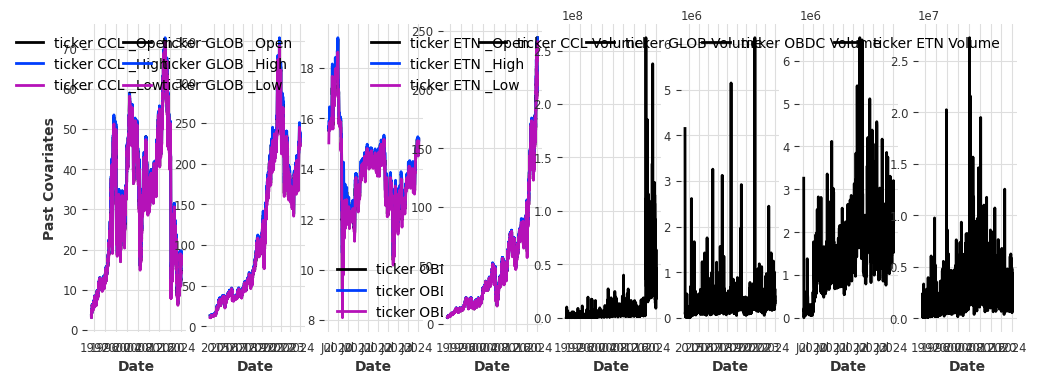

In [29]:
import matplotlib.pyplot as plt


n_plot_samples = 4
# plot sample of past covariates
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples*2, figsize=(12, 4))
for i,t in enumerate(past_covariates.keys()):
    if i < n_plot_samples:
        print(f'{t} past covariates components: {past_covariates[t].columns}')
        past_covariates[t].drop_columns(['Volume']).plot(label=f'ticker {t} ', ax=axes[i])
        past_covariates[t].univariate_component('Volume').plot(label=f'ticker {t} Volume ', ax=axes[n_plot_samples+i])

axes[0].set_ylabel('Past Covariates')


## Prepare Past Covariates

### Add sales and earnings calendar (past and forward looking) to past covariates
* Note: Research further if the data feed provides forward looking estimates at early enough dates to be seen by the model during training. It appears that some forward looking estimates are provided with a date column with value after the actual date they have become avaible.

In [30]:
import pandas as pd

earnings_loaded_df = pd.read_csv('data/earnings_calendar.csv.bz2')
print(earnings_loaded_df)

      symbol        date     eps  epsEstimated time       revenue  \
0       AAON  2024-11-04     NaN           NaN  amc           NaN   
1       AAON  2024-08-01     NaN           NaN  amc           NaN   
2       AAON  2024-05-02     NaN           NaN  amc           NaN   
3       AAON  2024-02-26     NaN          0.53  bmo           NaN   
4       AAON  2023-11-06  0.6400          0.55  amc  3.119700e+08   
...      ...         ...     ...           ...  ...           ...   
25945    ZTS  2012-03-31  0.2311           NaN  bmo  1.047000e+09   
25946    ZTS  2011-12-31  0.0180           NaN  bmo  1.127000e+09   
25947    ZTS  2011-09-30  0.1880           NaN  bmo  1.049000e+09   
25948    ZTS  2011-06-30  0.1320           NaN  bmo  1.074000e+09   
25949    ZTS  2011-03-31  0.1583           NaN  bmo  9.830000e+08   

       revenueEstimated updatedFromDate fiscalDateEnding  
0                   NaN      2024-01-12       2024-09-30  
1                   NaN      2024-01-12       2024-06

In [31]:
earnings_loaded_df.index.is_unique

True

In [32]:
earnings_loaded_df.index

RangeIndex(start=0, stop=25950, step=1)

In [33]:
len(earnings_loaded_df.index)

25950

In [34]:
earnings_loaded_df['date'] = pd.to_datetime(earnings_loaded_df['date'])

In [35]:
earnings_unique = earnings_loaded_df.drop_duplicates(subset=['symbol', 'date'])


In [36]:
earnings_unique.duplicated().any()

False

In [37]:
earnings_unique

,symbol,date,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate,fiscalDateEnding
0,AAON,2024-11-04,NaN,NaN,amc,NaN,NaN,2024-01-12,2024-09-30
1,AAON,2024-08-01,NaN,NaN,amc,NaN,NaN,2024-01-12,2024-06-30
2,AAON,2024-05-02,NaN,NaN,amc,NaN,NaN,2024-01-12,2024-03-30
3,AAON,2024-02-26,NaN,0.53,bmo,NaN,294360000.0,2024-01-12,2023-12-30
4,AAON,2023-11-06,0.6400,0.55,amc,3.119700e+08,294360000.0,2024-01-12,2023-09-30
...,...,...,...,...,...,...,...,...,...
25945,ZTS,2012-03-31,0.2311,NaN,bmo,1.047000e+09,NaN,2023-12-04,2012-03-31
25946,ZTS,2011-12-31,0.0180,NaN,bmo,1.127000e+09,NaN,2023-12-04,2011-12-31
25947,ZTS,2011-09-30,0.1880,NaN,bmo,1.049000e+09,NaN,2023-12-04,2011-09-30
25948,ZTS,2011-06-30,0.1320,NaN,bmo,1.074000e+09,NaN,2023-12-04,2011-06-30


In [38]:
earnings_unique = earnings_unique.set_index(keys=['symbol', 'date'])

In [39]:
earnings_unique

eps  epsEstimated time       revenue  revenueEstimated  \
symbol date                                                                    
AAON   2024-11-04     NaN           NaN  amc           NaN               NaN   
       2024-08-01     NaN           NaN  amc           NaN               NaN   
       2024-05-02     NaN           NaN  amc           NaN               NaN   
       2024-02-26     NaN          0.53  bmo           NaN       294360000.0   
       2023-11-06  0.6400          0.55  amc  3.119700e+08       294360000.0   
...                   ...           ...  ...           ...               ...   
ZTS    2012-03-31  0.2311           NaN  bmo  1.047000e+09               NaN   
       2011-12-31  0.0180           NaN  bmo  1.127000e+09               NaN   
       2011-09-30  0.1880           NaN  bmo  1.049000e+09               NaN   
       2011-06-30  0.1320           NaN  bmo  1.074000e+09               NaN   
       2011-03-31  0.1583           NaN  bmo  9.830000e+08               NaN   

                  updatedFromDate fiscalDateEnding  
symbol date                                         
AAON   2024-11-04      2024-01-12       2024-09-30  
       2024-08-01      2024-01-12       2024-06-30  
       2024-05-02      2024-01-12       2024-03-30  
       2024-02-26      2024-01-12       2023-12-30  
       2023-11-06      2024-01-12       2023-09-30  
...                           ...              ...  
ZTS    2012-03-31      2023-12-04       2012-03-31  
       2011-12-31      2023-12-04       2011-12-31  
       2011-09-30      2023-12-04       2011-09-30  
       2011-06-30      2023-12-04       2011-06-30  
       2011-03-31      2023-12-04       2011-03-31  

[25939 rows x 7 columns]

In [40]:
assert earnings_unique.index.has_duplicates == False

In [41]:
# check if data for a given symbol was saved and loaded as expected
earnings_unique.xs('AAON', level='symbol')

,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate,fiscalDateEnding
date,,,,,,,
2024-11-04,NaN,NaN,amc,NaN,NaN,2024-01-12,2024-09-30
2024-08-01,NaN,NaN,amc,NaN,NaN,2024-01-12,2024-06-30
2024-05-02,NaN,NaN,amc,NaN,NaN,2024-01-12,2024-03-30
2024-02-26,NaN,0.53,bmo,NaN,294360000.0,2024-01-12,2023-12-30
2023-11-06,0.64000,0.55,amc,311970000.0,294360000.0,2024-01-12,2023-09-30
...,...,...,...,...,...,...,...
1991-03-31,-0.00159,NaN,bmo,5700000.0,NaN,2023-12-04,1991-03-31
1990-12-31,0.00352,NaN,bmo,36100000.0,NaN,2023-12-04,1990-12-31
1990-09-30,0.00703,NaN,bmo,10100000.0,NaN,2023-12-04,1990-09-30


In [42]:
earnings_loaded_df = earnings_unique

In [43]:
# convert date strings to numerical representation
ufd = pd.to_datetime(earnings_loaded_df['updatedFromDate'])
ufd_year = ufd.dt.year
ufd_month = ufd.dt.month
ufd_day = ufd.dt.day

earn_n_cols = len(earnings_loaded_df.columns)
earnings_loaded_df.insert(loc=earn_n_cols, column='updatedFromDate_year', value=ufd_year)
earnings_loaded_df.insert(loc=earn_n_cols, column='updatedFromDate_month', value=ufd_month)
earnings_loaded_df.insert(loc=earn_n_cols, column='updatedFromDate_day', value=ufd_day)
earnings_loaded_df.pop('updatedFromDate')


symbol  date      
AAON    2024-11-04    2024-01-12
        2024-08-01    2024-01-12
        2024-05-02    2024-01-12
        2024-02-26    2024-01-12
        2023-11-06    2024-01-12
                         ...    
ZTS     2012-03-31    2023-12-04
        2011-12-31    2023-12-04
        2011-09-30    2023-12-04
        2011-06-30    2023-12-04
        2011-03-31    2023-12-04
Name: updatedFromDate, Length: 25939, dtype: object

In [44]:
earnings_loaded_df

eps  epsEstimated time       revenue  revenueEstimated  \
symbol date                                                                    
AAON   2024-11-04     NaN           NaN  amc           NaN               NaN   
       2024-08-01     NaN           NaN  amc           NaN               NaN   
       2024-05-02     NaN           NaN  amc           NaN               NaN   
       2024-02-26     NaN          0.53  bmo           NaN       294360000.0   
       2023-11-06  0.6400          0.55  amc  3.119700e+08       294360000.0   
...                   ...           ...  ...           ...               ...   
ZTS    2012-03-31  0.2311           NaN  bmo  1.047000e+09               NaN   
       2011-12-31  0.0180           NaN  bmo  1.127000e+09               NaN   
       2011-09-30  0.1880           NaN  bmo  1.049000e+09               NaN   
       2011-06-30  0.1320           NaN  bmo  1.074000e+09               NaN   
       2011-03-31  0.1583           NaN  bmo  9.830000e+08               NaN   

                  fiscalDateEnding  updatedFromDate_day  \
symbol date                                               
AAON   2024-11-04       2024-09-30                   12   
       2024-08-01       2024-06-30                   12   
       2024-05-02       2024-03-30                   12   
       2024-02-26       2023-12-30                   12   
       2023-11-06       2023-09-30                   12   
...                            ...                  ...   
ZTS    2012-03-31       2012-03-31                    4   
       2011-12-31       2011-12-31                    4   
       2011-09-30       2011-09-30                    4   
       2011-06-30       2011-06-30                    4   
       2011-03-31       2011-03-31                    4   

                   updatedFromDate_month  updatedFromDate_year  
symbol date                                                     
AAON   2024-11-04                      1                  2024  
       2024-08-01                      1                  2024  
       2024-05-02                      1                  2024  
       2024-02-26                      1                  2024  
       2023-11-06                      1                  2024  
...                                  ...                   ...  
ZTS    2012-03-31                     12                  2023  
       2011-12-31                     12                  2023  
       2011-09-30                     12                  2023  
       2011-06-30                     12                  2023  
       2011-03-31                     12                  2023  

[25939 rows x 9 columns]

In [45]:
# convert date strings to numerical representation
fde = pd.to_datetime(earnings_loaded_df['fiscalDateEnding'])
fde_year = ufd.dt.year
fde_month = ufd.dt.month
fde_day = ufd.dt.day

earn_n_cols = len(earnings_loaded_df.columns)
earnings_loaded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_year', value=fde_year)
earnings_loaded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_month', value=fde_month)
earnings_loaded_df.insert(loc=earn_n_cols, column='fiscalDateEnding_day', value=fde_day)
earnings_loaded_df.pop('fiscalDateEnding')


symbol  date      
AAON    2024-11-04    2024-09-30
        2024-08-01    2024-06-30
        2024-05-02    2024-03-30
        2024-02-26    2023-12-30
        2023-11-06    2023-09-30
                         ...    
ZTS     2012-03-31    2012-03-31
        2011-12-31    2011-12-31
        2011-09-30    2011-09-30
        2011-06-30    2011-06-30
        2011-03-31    2011-03-31
Name: fiscalDateEnding, Length: 25939, dtype: object

In [46]:
earnings_loaded_df

eps  epsEstimated time       revenue  revenueEstimated  \
symbol date                                                                    
AAON   2024-11-04     NaN           NaN  amc           NaN               NaN   
       2024-08-01     NaN           NaN  amc           NaN               NaN   
       2024-05-02     NaN           NaN  amc           NaN               NaN   
       2024-02-26     NaN          0.53  bmo           NaN       294360000.0   
       2023-11-06  0.6400          0.55  amc  3.119700e+08       294360000.0   
...                   ...           ...  ...           ...               ...   
ZTS    2012-03-31  0.2311           NaN  bmo  1.047000e+09               NaN   
       2011-12-31  0.0180           NaN  bmo  1.127000e+09               NaN   
       2011-09-30  0.1880           NaN  bmo  1.049000e+09               NaN   
       2011-06-30  0.1320           NaN  bmo  1.074000e+09               NaN   
       2011-03-31  0.1583           NaN  bmo  9.830000e+08               NaN   

                   updatedFromDate_day  updatedFromDate_month  \
symbol date                                                     
AAON   2024-11-04                   12                      1   
       2024-08-01                   12                      1   
       2024-05-02                   12                      1   
       2024-02-26                   12                      1   
       2023-11-06                   12                      1   
...                                ...                    ...   
ZTS    2012-03-31                    4                     12   
       2011-12-31                    4                     12   
       2011-09-30                    4                     12   
       2011-06-30                    4                     12   
       2011-03-31                    4                     12   

                   updatedFromDate_year  fiscalDateEnding_day  \
symbol date                                                     
AAON   2024-11-04                  2024                    12   
       2024-08-01                  2024                    12   
       2024-05-02                  2024                    12   
       2024-02-26                  2024                    12   
       2023-11-06                  2024                    12   
...                                 ...                   ...   
ZTS    2012-03-31                  2023                     4   
       2011-12-31                  2023                     4   
       2011-09-30                  2023                     4   
       2011-06-30                  2023                     4   
       2011-03-31                  2023                     4   

                   fiscalDateEnding_month  fiscalDateEnding_year  
symbol date                                                       
AAON   2024-11-04                       1                   2024  
       2024-08-01                       1                   2024  
       2024-05-02                       1                   2024  
       2024-02-26                       1                   2024  
       2023-11-06                       1                   2024  
...                                   ...                    ...  
ZTS    2012-03-31                      12                   2023  
       2011-12-31                      12                   2023  
       2011-09-30                      12                   2023  
       2011-06-30                      12                   2023  
       2011-03-31                      12                   2023  

[25939 rows x 11 columns]

In [47]:
# convert earnings reporting time - Before Market Open / After Market Close - categories to numerical representation
earnings_loaded_df['time'] = earnings_loaded_df['time'].replace(['bmo', 'amc', '--'],
                        [0, 1, -1], inplace=False).astype('int32')



In [48]:
earnings_loaded_df

eps  epsEstimated  time       revenue  revenueEstimated  \
symbol date                                                                     
AAON   2024-11-04     NaN           NaN     1           NaN               NaN   
       2024-08-01     NaN           NaN     1           NaN               NaN   
       2024-05-02     NaN           NaN     1           NaN               NaN   
       2024-02-26     NaN          0.53     0           NaN       294360000.0   
       2023-11-06  0.6400          0.55     1  3.119700e+08       294360000.0   
...                   ...           ...   ...           ...               ...   
ZTS    2012-03-31  0.2311           NaN     0  1.047000e+09               NaN   
       2011-12-31  0.0180           NaN     0  1.127000e+09               NaN   
       2011-09-30  0.1880           NaN     0  1.049000e+09               NaN   
       2011-06-30  0.1320           NaN     0  1.074000e+09               NaN   
       2011-03-31  0.1583           NaN     0  9.830000e+08               NaN   

                   updatedFromDate_day  updatedFromDate_month  \
symbol date                                                     
AAON   2024-11-04                   12                      1   
       2024-08-01                   12                      1   
       2024-05-02                   12                      1   
       2024-02-26                   12                      1   
       2023-11-06                   12                      1   
...                                ...                    ...   
ZTS    2012-03-31                    4                     12   
       2011-12-31                    4                     12   
       2011-09-30                    4                     12   
       2011-06-30                    4                     12   
       2011-03-31                    4                     12   

                   updatedFromDate_year  fiscalDateEnding_day  \
symbol date                                                     
AAON   2024-11-04                  2024                    12   
       2024-08-01                  2024                    12   
       2024-05-02                  2024                    12   
       2024-02-26                  2024                    12   
       2023-11-06                  2024                    12   
...                                 ...                   ...   
ZTS    2012-03-31                  2023                     4   
       2011-12-31                  2023                     4   
       2011-09-30                  2023                     4   
       2011-06-30                  2023                     4   
       2011-03-31                  2023                     4   

                   fiscalDateEnding_month  fiscalDateEnding_year  
symbol date                                                       
AAON   2024-11-04                       1                   2024  
       2024-08-01                       1                   2024  
       2024-05-02                       1                   2024  
       2024-02-26                       1                   2024  
       2023-11-06                       1                   2024  
...                                   ...                    ...  
ZTS    2012-03-31                      12                   2023  
       2011-12-31                      12                   2023  
       2011-09-30                      12                   2023  
       2011-06-30                      12                   2023  
       2011-03-31                      12                   2023  

[25939 rows x 11 columns]

In [49]:
from darts import TimeSeries

type(earnings_loaded_df.index)

pandas.core.indexes.multi.MultiIndex

In [50]:
earnings_loaded_df.index.names

FrozenList(['symbol', 'date'])

In [51]:
earnings_loaded_df.dtypes

eps                       float64
epsEstimated              float64
time                        int32
revenue                   float64
revenueEstimated          float64
updatedFromDate_day         int32
updatedFromDate_month       int32
updatedFromDate_year        int32
fiscalDateEnding_day        int32
fiscalDateEnding_month      int32
fiscalDateEnding_year       int32
dtype: object

In [52]:
t_earn_series = {}
for t in ticker_series.keys():
    t_earn = earnings_loaded_df.loc[[t]]
    t_earn = t_earn.droplevel('symbol')
    t_earn.index = pd.to_datetime(t_earn.index)
    print(f'index type for {t}: {type(t_earn.index)}')
    assert not t_earn.index.duplicated().any()
    print(f'{t} earnings: \n{t_earn}')
    tes = TimeSeries.from_dataframe(t_earn, fillna_value=-1, freq='D', fill_missing_dates=True)
    assert len(tes.gaps()) == 0
    t_earn_series[t] = tes


index type for CCL: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
CCL earnings: 
                eps  epsEstimated  time       revenue  revenueEstimated  \
date                                                                      
2024-12-19      NaN           NaN     0           NaN               NaN   
2024-09-27      NaN           NaN     0           NaN               NaN   
2024-06-24      NaN           NaN     0           NaN               NaN   
2024-03-25      NaN         -0.19     0           NaN      5.395220e+09   
2023-12-21 -0.07000         -0.12     0  5.396000e+09      5.435160e+09   
...             ...           ...   ...           ...               ...   
1987-02-28  0.04843           NaN     0  1.214000e+08               NaN   
1986-11-30  0.06493           NaN     0  1.052000e+08               NaN   
1986-08-31  0.05342           NaN     0  1.052000e+08               NaN   
1986-05-31  0.05342           NaN     0  1.052000e+08               NaN   
1986-02-28 

In [53]:
t_earn_series

{'CCL': <TimeSeries (DataArray) (date: 14175, component: 11, sample: 1)>
 array([[[ 5.319e-02],
         [-1.000e+00],
         [ 0.000e+00],
         ...,
         [ 4.000e+00],
         [ 1.200e+01],
         [ 2.023e+03]],
 
        [[-1.000e+00],
         [-1.000e+00],
         [-1.000e+00],
         ...,
         [-1.000e+00],
         [-1.000e+00],
         [-1.000e+00]],
 
        [[-1.000e+00],
         [-1.000e+00],
         [-1.000e+00],
         ...,
 ...
         ...,
         [-1.000e+00],
         [-1.000e+00],
         [-1.000e+00]],
 
        [[-1.000e+00],
         [-1.000e+00],
         [-1.000e+00],
         ...,
         [-1.000e+00],
         [-1.000e+00],
         [-1.000e+00]],
 
        [[-1.000e+00],
         [-1.000e+00],
         [ 0.000e+00],
         ...,
         [ 1.200e+01],
         [ 1.000e+00],
         [ 2.024e+03]]])
 Coordinates:
   * date       (date) datetime64[ns] 1986-02-28 1986-03-01 ... 2024-12-19
   * component  (component) object 'eps' ... 

Stack sales and earnings to past covariates

In [54]:
# future_covariates = {t: future_covariates[t].stack(t_earn_series[t]) for t in ticker_series.keys()}

new_past_covs = {}

for t, covs in list(past_covariates.items()):
    print(f'stacking future covs for {t}')
    past_covs_sliced = covs.slice_intersect(t_earn_series[t])
    earn_sliced = t_earn_series[t].slice_intersect(past_covs_sliced)
    new_past_covs[t] = past_covs_sliced.stack(earn_sliced)
    print(f'past covariates for {t} including earnings calendar: \n{new_past_covs[t].components}')
    print(f'past covariates for {t} start time: {new_past_covs[t].start_time()}, end time: {new_past_covs[t].end_time()}')
    print(f'past covariates for {t} sample: \n{new_past_covs[t][0].pd_dataframe()}')



stacking future covs for CCL
past covariates for CCL including earnings calendar: 
Index(['Open', 'High', 'Low', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       'updatedFromDate_month', 'updatedFromDate_year', 'fiscalDateEnding_day',
       'fiscalDateEnding_month', 'fiscalDateEnding_year'],
      dtype='object', name='component')
past covariates for CCL start time: 1991-01-01 00:00:00, end time: 2024-01-12 00:00:00
past covariates for CCL sample: 
component       Open      High       Low    Volume  eps  epsEstimated  time  \
Date                                                                          
1991-01-01  3.515625  3.546875  3.484375  371800.0 -1.0          -1.0  -1.0   

component   revenue  revenueEstimated  updatedFromDate_day  \
Date                                                         
1991-01-01     -1.0              -1.0                 -1.0   

component   updatedFromDate_month  updatedFromDate_year  fisc

In [55]:
past_covariates = new_past_covs

In [56]:
t

'SHW'

In [57]:
past_covariates[t].start_time(), past_covariates[t].end_time()

(Timestamp('1991-01-01 00:00:00'), Timestamp('2024-01-12 00:00:00'))

In [58]:
print(f'past covariates with price and earnings sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates with price and earnings sample: component       Open      High       Low     Volume  eps  epsEstimated  time  \
Date                                                                           
1991-01-01  3.109375  3.114583  3.052083   700800.0 -1.0          -1.0  -1.0   
1991-01-02  3.114583  3.114583  3.020833   702000.0 -1.0          -1.0  -1.0   
1991-01-03  3.041667  3.062500  3.031250  1548000.0 -1.0          -1.0  -1.0   
1991-01-04  3.062500  3.083333  3.041667   696000.0 -1.0          -1.0  -1.0   
1991-01-05  3.052083  3.072916  3.024306   880800.0 -1.0          -1.0  -1.0   

component   revenue  revenueEstimated  updatedFromDate_day  \
Date                                                         
1991-01-01     -1.0              -1.0                 -1.0   
1991-01-02     -1.0              -1.0                 -1.0   
1991-01-03     -1.0              -1.0                 -1.0   
1991-01-04     -1.0              -1.0                 -1.0   
1991-01-05     -1.0

In [59]:
t_earn_series[t].start_time(), t_earn_series[t].end_time()

(Timestamp('1989-06-30 00:00:00'), Timestamp('2024-09-27 00:00:00'))

### Stack broad market indicators to past covariates

In [60]:
broad_market_df = pd.read_csv('data/broad_market.csv.bz2', header=[0, 1], index_col=0)

# drop Close as redundand
broad_market_df = broad_market_df.drop(columns=['Close'], level=1)

# use a subset of indicies for testing
# broad_market_df = broad_market_df[(broad_market_df.columns[:1])]

#flatten column hierarchy so Darts can use as covariate series
broad_market_df.columns = [f'{i}_{j}' for i, j in broad_market_df.columns]

# CBOE VIX volatility, DYX USD and TNT 10Y Treasury indices do not have meaningful values for Volume
broad_market_df = broad_market_df.drop(columns=['^VIX_Volume', 'DX-Y.NYB_Volume', '^TNX_Volume'])

# fix datetime index type issue
# https://stackoverflow.com/questions/48248239/pandas-how-to-convert-rangeindex-into-datetimeindex
broad_market_df.index = pd.to_datetime(broad_market_df.index)

broad_market_df

,^R2ESC_Open,^R2ESC_High,^R2ESC_Low,^R2ESC_Adj Close,^R2ESC_Volume,^NDXE_Open,^NDXE_High,^NDXE_Low,^NDXE_Adj Close,^NDXE_Volume,...,^SPX_Volume,^RUT_Open,^RUT_High,^RUT_Low,^RUT_Adj Close,^RUT_Volume,DX-Y.NYB_Open,DX-Y.NYB_High,DX-Y.NYB_Low,DX-Y.NYB_Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
1927-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1928-01-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-08,NaN,NaN,NaN,NaN,NaN,6963.899902,7080.100098,6961.339844,7078.250000,838300.0,...,3.742320e+09,1948.900024,1989.010010,1944.859985,1989.010010,3.742320e+09,102.440002,102.620003,102.080002,102.209999
2024-01-09,NaN,NaN,NaN,NaN,NaN,7018.589844,7092.770020,7018.589844,7078.229980,800400.0,...,3.529960e+09,1964.719971,1975.229980,1957.420044,1968.040039,3.529960e+09,102.220001,102.660004,102.110001,102.570000
2024-01-10,NaN,NaN,NaN,NaN,NaN,7078.689941,7111.020020,7046.439941,7097.189941,746700.0,...,3.498680e+09,1965.469971,1971.250000,1953.000000,1970.260010,3.498680e+09,102.480003,102.639999,102.339996,102.360001


In [61]:
broad_market_series = TimeSeries.from_dataframe(broad_market_df, freq='D')
broad_market_series = broad_market_series.slice(train_date_start, broad_market_series.end_time())
broad_market_series

<TimeSeries (DataArray) (Date: 12065, component: 42, sample: 1)>
array([[[          nan],
        [          nan],
        [          nan],
        ...,
        [  83.43000031],
        [  83.01000214],
        [  83.06999969]],

       [[          nan],
        [          nan],
        [          nan],
        ...,
        [  83.08000183],
        [  82.66000366],
        [  82.79000092]],

       [[          nan],
        [          nan],
        [          nan],
        ...,
...
        ...,
        [ 102.63999939],
        [ 102.33999634],
        [ 102.36000061]],

       [[          nan],
        [          nan],
        [          nan],
        ...,
        [ 102.76000214],
        [ 102.16000366],
        [ 102.29000092]],

       [[4247.75537109],
        [4324.00976562],
        [4239.99316406],
        ...,
        [ 102.58699799],
        [ 102.08699799],
        [ 102.43900299]]])
Coordinates:
  * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2024-01-12
  * component  (component) object '^R2ESC_Open' ... 'DX-Y.NYB_Adj Close'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None

In [62]:
broad_market_series.gaps()


,gap_start,gap_end,gap_size
0,1991-01-05,1991-01-06,2
1,1991-01-12,1991-01-13,2
2,1991-01-19,1991-01-20,2
3,1991-01-26,1991-01-27,2
4,1991-02-02,1991-02-03,2
...,...,...,...
1766,2023-12-09,2023-12-10,2
1767,2023-12-16,2023-12-17,2
1768,2023-12-23,2023-12-25,3
1769,2023-12-30,2024-01-01,3


In [63]:

filler = MissingValuesFiller()

series_filled = filler.transform(broad_market_series)
assert len(series_filled.gaps()) == 0

In [64]:
broad_market_series = series_filled


In [65]:
# scale series to avoid exploding gradients
#bm_scaler = Scaler(verbose=True, n_jobs=-1)
#for c in broad_market_series.columns:
#    broad_market_series[c] = 
#broad_market_series = bm_scaler.fit_transform(series=broad_market_series)
#broad_market_series

In [66]:
print(f'past covariates without broad market indicies: {past_covariates[t].components}')


past covariates without broad market indicies: Index(['Open', 'High', 'Low', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       'updatedFromDate_month', 'updatedFromDate_year', 'fiscalDateEnding_day',
       'fiscalDateEnding_month', 'fiscalDateEnding_year'],
      dtype='object', name='component')


In [67]:
print(f'past covariates without broad market indicies sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates without broad market indicies sample: component       Open      High       Low     Volume  eps  epsEstimated  time  \
Date                                                                           
1991-01-01  3.109375  3.114583  3.052083   700800.0 -1.0          -1.0  -1.0   
1991-01-02  3.114583  3.114583  3.020833   702000.0 -1.0          -1.0  -1.0   
1991-01-03  3.041667  3.062500  3.031250  1548000.0 -1.0          -1.0  -1.0   
1991-01-04  3.062500  3.083333  3.041667   696000.0 -1.0          -1.0  -1.0   
1991-01-05  3.052083  3.072916  3.024306   880800.0 -1.0          -1.0  -1.0   

component   revenue  revenueEstimated  updatedFromDate_day  \
Date                                                         
1991-01-01     -1.0              -1.0                 -1.0   
1991-01-02     -1.0              -1.0                 -1.0   
1991-01-03     -1.0              -1.0                 -1.0   
1991-01-04     -1.0              -1.0                 -1.0   
1991-01-05   

In [68]:
for t, covs in past_covariates.items():
    bm_sliced = broad_market_series.slice_intersect(covs)
    past_covariates[t] = covs.stack(bm_sliced)
    # print(f'past covariates for {t} including broad market indicies: {past_covariates[t].components}')


In [69]:
print(f'past covariates with broad market indicies components: {past_covariates[t].components}')


past covariates with broad market indicies components: Index(['Open', 'High', 'Low', 'Volume', 'eps', 'epsEstimated', 'time',
       'revenue', 'revenueEstimated', 'updatedFromDate_day',
       'updatedFromDate_month', 'updatedFromDate_year', 'fiscalDateEnding_day',
       'fiscalDateEnding_month', 'fiscalDateEnding_year', '^R2ESC_Open',
       '^R2ESC_High', '^R2ESC_Low', '^R2ESC_Adj Close', '^R2ESC_Volume',
       '^NDXE_Open', '^NDXE_High', '^NDXE_Low', '^NDXE_Adj Close',
       '^NDXE_Volume', '^VIX_Open', '^VIX_High', '^VIX_Low', '^VIX_Adj Close',
       '^NDX_Open', '^NDX_High', '^NDX_Low', '^NDX_Adj Close', '^NDX_Volume',
       '^TNX_Open', '^TNX_High', '^TNX_Low', '^TNX_Adj Close', '^SPXEW_Open',
       '^SPXEW_High', '^SPXEW_Low', '^SPXEW_Adj Close', '^SPXEW_Volume',
       '^SPX_Open', '^SPX_High', '^SPX_Low', '^SPX_Adj Close', '^SPX_Volume',
       '^RUT_Open', '^RUT_High', '^RUT_Low', '^RUT_Adj Close', '^RUT_Volume',
       'DX-Y.NYB_Open', 'DX-Y.NYB_High', 'DX-Y.NYB_Low',

In [70]:
print(f'past covariates with broad market indicies sample: {past_covariates[t][0:5].pd_dataframe()}')


past covariates with broad market indicies sample: component       Open      High       Low     Volume  eps  epsEstimated  time  \
Date                                                                           
1991-01-01  3.109375  3.114583  3.052083   700800.0 -1.0          -1.0  -1.0   
1991-01-02  3.114583  3.114583  3.020833   702000.0 -1.0          -1.0  -1.0   
1991-01-03  3.041667  3.062500  3.031250  1548000.0 -1.0          -1.0  -1.0   
1991-01-04  3.062500  3.083333  3.041667   696000.0 -1.0          -1.0  -1.0   
1991-01-05  3.052083  3.072916  3.024306   880800.0 -1.0          -1.0  -1.0   

component   revenue  revenueEstimated  updatedFromDate_day  ...   ^SPX_Volume  \
Date                                                        ...                 
1991-01-01     -1.0              -1.0                 -1.0  ...  1.262800e+08   
1991-01-02     -1.0              -1.0                 -1.0  ...  1.262800e+08   
1991-01-03     -1.0              -1.0                 -1.0  ... 

### Relign target series with past covariates

In [71]:
for t, covs in past_covariates.items():
    ts_sliced = ticker_series[t].slice_intersect(covs)
    ticker_series[t] = ts_sliced

## Prepare Future Covariates

In [72]:

future_covariates = {t: ticker_series[t].univariate_component('holidays') for t in ticker_series.keys()}
future_covariates

{'CCL': <TimeSeries (DataArray) (Date: 12065, component: 1, sample: 1)>
 array([[[1.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2024-01-12
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'GLOB': <TimeSeries (DataArray) (Date: 3466, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
        [[0.]],
 
        ...,
 
        [[0.]],
 
        [[0.]],
 
        [[0.]]])
 Coordinates:
   * Date       (Date) datetime64[ns] 2014-07-18 2014-07-19 ... 2024-01-12
   * component  (component) object 'holidays'
 Dimensions without coordinates: sample
 Attributes:
     static_covariates:  None
     hierarchy:          None,
 'OBDC': <TimeSeries (DataArray) (Date: 1640, component: 1, sample: 1)>
 array([[[0.]],
 
        [[0.]],
 
      

Prepare train and validation splits

In [73]:
val_start = pd.Timestamp('2023-05-05')
train_series = {}
val_series = {}
past_covariates_train = {}
past_covariates_val = {}

for t, target in target_series.items():
    train, val = target.split_before(val_start)
    # there should be no gaps in the training data
    assert(len(train.gaps().index) == 0)
    train_series[t] = train
    val_series[t] = val
    past_train, past_val = past_covariates[t].split_before(val_start)
    # there should be no gaps in the training data
    assert(len(past_train.gaps().index) == 0)
    past_covariates_train[t] = past_train 
    past_covariates_val = past_val



In [74]:
train_series, val_series

({'CCL': <TimeSeries (DataArray) (Date: 11812, component: 1, sample: 1)>
  array([[[1.9121418 ]],
  
         [[1.9121418 ]],
  
         [[1.87829816]],
  
         ...,
  
         [[9.44999981]],
  
         [[9.43000031]],
  
         [[9.39000034]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 1991-01-01 1991-01-02 ... 2023-05-04
    * component  (component) object 'Adj Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates:  None
      hierarchy:          None,
  'GLOB': <TimeSeries (DataArray) (Date: 3213, component: 1, sample: 1)>
  array([[[ 11.25      ]],
  
         [[ 11.33666674]],
  
         [[ 11.42333349]],
  
         ...,
  
         [[152.77000427]],
  
         [[152.07000732]],
  
         [[150.8999939 ]]])
  Coordinates:
    * Date       (Date) datetime64[ns] 2014-07-18 2014-07-19 ... 2023-05-04
    * component  (component) object 'Adj Close'
  Dimensions without coordinates: sample
  Attributes:
      static_covariates: 

In [75]:
past_covariates_train, past_covariates_val

({'CCL': <TimeSeries (DataArray) (Date: 11812, component: 57, sample: 1)>
  array([[[  3.515625  ],
          [  3.546875  ],
          [  3.484375  ],
          ...,
          [ 83.43000031],
          [ 83.01000214],
          [ 83.06999969]],
  
         [[  3.5       ],
          [  3.53125   ],
          [  3.5       ],
          ...,
          [ 83.08000183],
          [ 82.66000366],
          [ 82.79000092]],
  
         [[  3.5       ],
          [  3.5       ],
          [  3.46875   ],
          ...,
  ...
          ...,
          [102.40000153],
          [101.87999725],
          [101.95999908]],
  
         [[  9.46000004],
          [  9.69999981],
          [  9.40999985],
          ...,
          [101.91999817],
          [101.06999969],
          [101.33999634]],
  
         [[  9.77999973],
          [  9.84000015],
          [  9.21000004],
          ...,
          [101.63999939],
          [101.02999878],
          [101.40000153]]])
  Coordinates:
    * Date       

Plot data splits

Text(0, 0.5, 'Target Series')

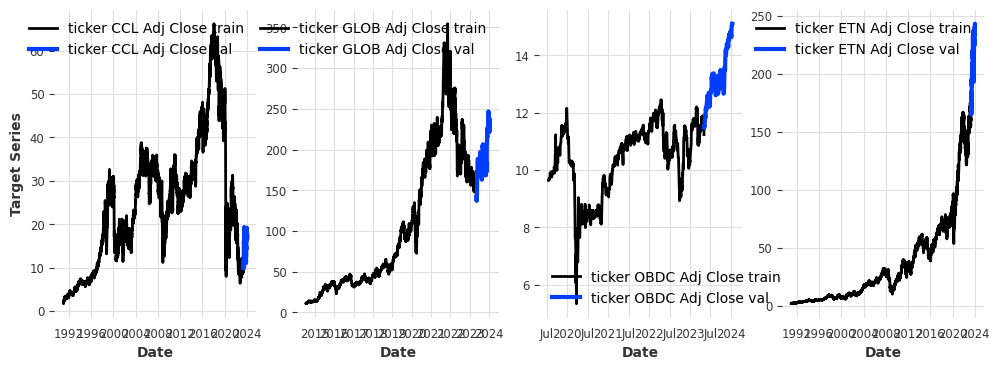

In [76]:
import matplotlib.pyplot as plt

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i > n_plot_samples-1:
        break
    train_series[t].plot(label=f'ticker {t} {train_series[t].columns[0]} train', ax=axes[i])
    val_series[t].plot(label=f'ticker {t} {train_series[t].columns[0]} val', lw=3, ax=axes[i])

axes[0].set_ylabel('Target Series')


Show seasonalities

Text(0, 0.5, 'Seasonality')

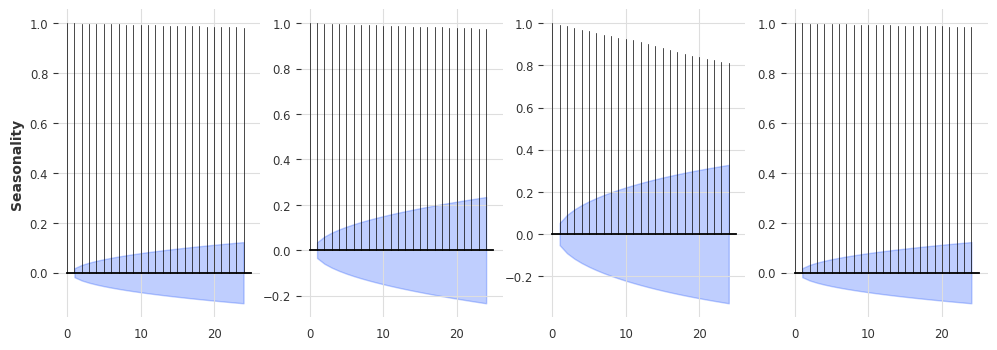

In [77]:
from darts.utils.statistics import plot_acf, check_seasonality

# plot sample of target series
fig, axes = plt.subplots(nrows=1, ncols=n_plot_samples, figsize=(12, 4))
for i,t in enumerate(target_series.keys()):
    if i == n_plot_samples:
        break
    plot_acf(train_series[t], alpha=0.05, axis=axes[i])

axes[0].set_ylabel('Seasonality')



Train our current working model

Prepare Encoders that Darts will automatically use for training and inference

In [78]:
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.dataprocessing import Pipeline
# 
scaler = Scaler(verbose=True, n_jobs=-1)

# darts encoder examples: https://unit8co.github.io/darts/generated_api/darts.dataprocessing.encoders.encoders.html#
encoders = {
    'cyclic': {'future': ['dayofweek', 'month', 'quarter']},
    "datetime_attribute": {"future": ["dayofweek", "month", "quarter", "year"]}, 
    'position': {'past': ['relative'], 'future': ['relative']},
    'custom': {'future': [lambda idx: (idx.year % 4)]},  # signal proximity to US election years, which is known to have significance to market cycles.
    # "transformer": scaler
}



In [79]:
train_history = 252*2 # 252 days in a year with market data
pred_horizon = 21*2 # 21 days in a month with market data
n_epochs = 20 # model training epochs

Model hyperparameter selection

In [80]:
# based on Darts template: https://unit8co.github.io/darts/examples/18-TiDE-examples.html#Model-Parameter-Setup

optimizer_kwargs = {
    "lr": 1e-3,
}

# PyTorch Lightning Trainer arguments
pl_trainer_kwargs = {
    "gradient_clip_val": 1,
    "max_epochs": 200,
    "accelerator": "auto",
    "callbacks": [],
}

# learning rate scheduler
lr_scheduler_cls = torch.optim.lr_scheduler.ExponentialLR
lr_scheduler_kwargs = {
    "gamma": 0.999,
}

# early stopping (needs to be reset for each model later on)
# this setting stops training once the the validation loss has not decreased by more than 1e-3 for 10 epochs
early_stopping_args = {
    "monitor": "val_loss",
    "patience": 10,
    "min_delta": 1e-3,
    "mode": "min",
}

#
common_model_args = {
    # "input_chunk_length": 12,  # lookback window
    # "output_chunk_length": 12,  # forecast/lookahead window
    "optimizer_kwargs": optimizer_kwargs,
    "pl_trainer_kwargs": pl_trainer_kwargs,
    "lr_scheduler_cls": lr_scheduler_cls,
    "lr_scheduler_kwargs": lr_scheduler_kwargs,
    # "likelihood": None,  # use a likelihood for probabilistic forecasts
    # "save_checkpoints": True,  # checkpoint to retrieve the best performing model state,
    # "force_reset": True,
    "batch_size": 256,
    "random_state": 42,
}

In [81]:
from darts.models import TiDEModel

from darts.utils.likelihood_models import QuantileRegression

saved_model_name = 'data/canswim_model.pt'
model = None

# If available, load the saved model state that performed best on validation set
try:
  print('Loading saved model')
  model = TiDEModel.load(saved_model_name)  
except Exception as e:
  print('Error loading saved model:', e)
  print('Creating a new model')
  model = TiDEModel(
      **common_model_args,
      input_chunk_length=train_history,
      output_chunk_length=pred_horizon,
      use_layer_norm=True,
      add_encoders=None, # encoders,
      dropout=0.1,
      n_epochs=n_epochs,
      use_reversible_instance_norm=True,
      likelihood=QuantileRegression(quantiles=[0.01, 0.05, 0.2, 0.5, 0.8, 0.95, 0.99]),
      model_name=saved_model_name,
  )
  


Loading saved model
Error loading saved model: [Errno 2] No such file or directory: 'data/canswim_model.pt'
Creating a new model


In [82]:
from darts.models import RegressionModel
from darts.models.forecasting.forecasting_model import GlobalForecastingModel

# when True, multiple time series are supported
supports_multi_ts = issubclass(model.__class__, GlobalForecastingModel)
supports_multi_ts

True

In [83]:
targets_list = [series for ticker, series in sorted(target_series.items())]
target_train_list = [series for ticker, series in sorted(train_series.items())]
print(len(target_train_list))
target_val_list = [series for ticker, series in sorted(val_series.items())]
print(len(target_train_list))
past_cov_list = [series for ticker, series in sorted(past_covariates_train.items())]
print(len(past_cov_list))
future_cov_list = [series for ticker, series in sorted(future_covariates.items())]
print(len(future_cov_list))


8
8
8
8


In [84]:
type(target_train_list[0])

darts.timeseries.TimeSeries

In [85]:
print(len(target_train_list[0].time_index))
print(len(past_cov_list[0].time_index))
print(len(future_cov_list[0].time_index))


11812
11812
12065


In [86]:
target_train_list[0].pd_dataframe()

component,Adj Close
Date,
1991-01-01,1.912142
1991-01-02,1.912142
1991-01-03,1.878298
1991-01-04,1.844456
1991-01-05,1.816253
...,...
2023-04-30,9.396667
2023-05-01,9.490000
2023-05-02,9.450000


In [87]:
target_train_list[0].start_time(), target_train_list[0].end_time()

(Timestamp('1991-01-01 00:00:00'), Timestamp('2023-05-04 00:00:00'))

In [88]:
past_cov_list[0].pd_dataframe()

component,Open,High,Low,Volume,eps,epsEstimated,time,revenue,revenueEstimated,updatedFromDate_day,...,^SPX_Volume,^RUT_Open,^RUT_High,^RUT_Low,^RUT_Adj Close,^RUT_Volume,DX-Y.NYB_Open,DX-Y.NYB_High,DX-Y.NYB_Low,DX-Y.NYB_Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
1991-01-01,3.515625,3.546875,3.484375,3.718000e+05,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.262800e+08,132.190002,132.190002,131.389999,131.649994,1.262800e+08,83.370003,83.430000,83.010002,83.070000
1991-01-02,3.500000,3.531250,3.500000,4.432000e+05,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.262800e+08,132.190002,132.190002,131.389999,131.649994,1.262800e+08,82.930000,83.080002,82.660004,82.790001
1991-01-03,3.500000,3.500000,3.468750,2.960000e+05,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.414500e+08,131.639999,131.639999,130.289993,130.350006,1.414500e+08,82.889999,82.930000,82.680000,82.809998
1991-01-04,3.437500,3.437500,3.375000,1.892000e+05,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.408200e+08,130.350006,130.350006,129.690002,130.210007,1.408200e+08,82.669998,83.519997,82.599998,83.360001
1991-01-05,3.427083,3.427083,3.333333,2.122667e+05,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1.374167e+08,130.300003,130.300003,129.180003,129.540003,1.374167e+08,83.403333,84.049998,83.246666,83.796666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-30,9.126667,9.520000,9.083333,4.066593e+07,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,3.576847e+09,1760.249959,1781.139974,1758.493286,1769.136637,3.576847e+09,101.603333,102.183334,101.553335,101.990000
2023-05-01,9.270000,9.630000,9.210000,4.394510e+07,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,3.321370e+09,1765.449951,1785.199951,1764.319946,1769.209961,3.321370e+09,101.669998,102.190002,101.620003,102.150002
2023-05-02,9.380000,9.540000,9.170000,3.339620e+07,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,4.486130e+09,1761.150024,1761.150024,1716.219971,1732.109985,4.486130e+09,102.150002,102.400002,101.879997,101.959999


In [89]:
past_cov_list[0].start_time(), past_cov_list[0].end_time()

(Timestamp('1991-01-01 00:00:00'), Timestamp('2023-05-04 00:00:00'))

In [90]:
n_holidays = future_cov_list[0].pd_dataframe().sum()
n_holidays

component
holidays    375.0
dtype: float64

In [91]:
future_cov_list[0].start_time(), future_cov_list[0].end_time()

(Timestamp('1991-01-01 00:00:00'), Timestamp('2024-01-12 00:00:00'))

In [92]:
# train model
# for i in range(100):
model.fit(target_train_list, epochs=n_epochs, past_covariates=past_cov_list, future_covariates=future_cov_list, verbose=True, num_loader_workers=10, )
          # val_series=target_val_list[0]) # , val_future_covariates=future_cov_list[0]) 



number of `future_covariates` features is <= `temporal_width_future`, leading to feature expansion.number of covariates: 1, `temporal_width_future=4`.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name                  | Type             | Params
-----------------------------------------------------------
0 | criterion             | MSELoss          | 0     
1 | train_metrics         | MetricCollection | 0     
2 | val_metrics           | MetricCollection | 0     
3 | rin                   | RINorm           | 2     
4 | past_cov_projection   | _ResidualBlock   | 8.2 K 
5 | future_cov_projection | _ResidualBlock   | 788   
6 | encoders              | Sequential       | 1.2 M 
7 | decoders              | Sequential       | 1.2 M 
8 | temporal_decoder      | _ResidualBlock   | 4.8 K 
9 | lookback_skip         | Linear           | 148 K 
-----------------------------------------------

Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
# save model checkpoint
model.save(saved_model_name)


In [ ]:
# use probabilistic prediction
# see https://unit8co.github.io/darts/userguide/forecasting_overview.html#probabilistic-forecasts
pred = model.predict(pred_horizon, series=target_train_list, mc_dropout=True, num_samples=500, past_covariates=past_cov_list, future_covariates=future_cov_list)

In [ ]:
pred[0]

In [ ]:
pred[0].gaps()

In [ ]:
#pred2_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=60))
#pred2 = model.predict(pred_horizon, series=pred2_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred2

In [ ]:
#pred3_series = target.slice(target.start_time(), pred2_series.end_time()+pd.Timedelta(days=60))
#pred3 = model.predict(pred_horizon, series=pred3_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred3

In [ ]:
#pred4_series = target.slice(target.start_time(), pred3_series.end_time()+pd.Timedelta(days=60))
#pred4 = model.predict(pred_horizon, series=pred4_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred4

In [ ]:
#pred5_series = target.slice(target.start_time(), val_start+pd.Timedelta(days=30))
#pred5 = model.predict(pred_horizon, series=pred5_series, past_covariates=past_covariates, future_covariates=future_covariates, mc_dropout=True, num_samples=500) #   len(val)) 
#pred5

In [ ]:
import matplotlib.dates as mdates

# select a reasonable range of train and val data points for convenient visualization of results
actual = {}

fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(12, 12))

for i,t in enumerate(sorted(train_series.keys())):
    if i < n_plot_samples:
        tsliced = target_series[t]
        actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
        ax = actual[t].plot(label='actual', ax=axes[i])
        pred[i].plot(label=f'forecast {val_start} + {pred_horizon}', linewidth=3, ax=axes[i])
        #pred2.plot(label=f'forecast {pred2_series.end_time()} + {pred_horizon}')
        #pred3.plot(label=f'forecast {pred3_series.end_time()} + {pred_horizon}')
        #pred4.plot(label=f'forecast {pred4_series.end_time()} + {pred_horizon}')
        #pred5.plot(label=f'forecast {pred5_series.end_time()} + {pred_horizon}')
        plt.legend()

        # Major ticks every half year, minor ticks every month,
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(True)
        ax.set_ylabel(f'{t}')




Backtest Model


Backtest model on the full range of test data

In [ ]:
from darts.metrics import rmse

def eval_model(model=None, series=None, start=None, past_covariates=None, future_covariates=None, forecast_horizon=None):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the val portion of the flow series, with a forecast_horizon:
    backtest = model.historical_forecasts(series=series, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=start, 
                                          retrain=False,
                                          verbose=True, 
                                          forecast_horizon=forecast_horizon,
                                          overlap_end=True,
                                          num_samples=500, # probabilistic forecasting
                                          predict_kwargs={'mc_dropout': True, 'num_loader_workers': 10, 'n_jobs': -1}
                                          )
    
    return backtest


In [ ]:
# set the forecast start at a time before the validation date in order to see 
# the difference between predicting on training vs validation data
# predicting up to the validate date should be near match to actuals
# whereas predicting on unseen validate data should have room for improvement
forecast_start = val_start-pd.Timedelta(days=120)
forecast_horizon = pred_horizon # pred_horizon

backtest = eval_model(model=model, series=targets_list, start=forecast_start, forecast_horizon=forecast_horizon, past_covariates=past_cov_list, future_covariates=future_cov_list)


In [ ]:

fig, axes = plt.subplots(nrows=n_plot_samples, ncols=1, figsize=(12, 12))

for i,t in enumerate(sorted(train_series.keys())):
    if i < n_plot_samples:
        tsliced = target_series[t]
        actual[t] = tsliced.slice(val_start-pd.Timedelta(days=train_history), target.end_time())
        ax = actual[t].plot(label='actual', ax=axes[i])
        backtest[i].plot(label=f'backtest (forecast_horizon={forecast_horizon})', linewidth=3, ax=axes[i])
        plt.legend()

        # Major ticks every half year, minor ticks every month,
        ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(13)))
        ax.xaxis.set_minor_locator(mdates.MonthLocator())
        ax.grid(True)
        ax.set_ylabel(f'{t}')



In [ ]:
print('Backtest RMSE = {}'.format(rmse(target_train_list, backtest)))
